In [6]:
#!python3 -m spacy download en
import pysolr
import requests
import json
import pandas as pd
import os
from datetime import datetime

base_directory = os.getcwd()
print(base_directory)

# Setup a Solr instance. The timeout is optional.
solr = pysolr.Solr('http://pcalleja.oeg-upm.net/8983/solr/covid-sentences')

counter = 0
completed = False
window_size=1000
cursor = "*"
drugs={}
atc_code="bionlp_atc5_t"
print("reading sentences...")
while (not completed):
    old_counter = counter
    solr_query=atc_code+":[* TO *] AND scispacy_diseases_t:[* TO *]"
    try:
        sentences = solr.search(q=solr_query,rows=window_size,cursorMark=cursor,sort="id asc")
        cursor = sentences.nextCursorMark
        counter += len(sentences)
        for sentence in sentences:
            drugs_atc = sentence[atc_code].split(" ")
            #symptoms = sentence['scispacy_diseases_t'].split(" ")
            symptoms = sentence['text_t'].split(" ")
            for drug_atc in drugs_atc:
                if (not drug_atc in drugs):
                    drugs[drug_atc]=[]
                drugs[drug_atc].extend(symptoms)
        if (old_counter == counter):
            print("done!")
            break
    except:
        print("Solr query error. Wait for 5secs..")
        time.sleep(5.0)
        
labels=[]
texts = []
for drug in drugs:
    labels.append(drug)
    texts.append(drugs[drug])

data = {}
data['drug']=labels
data['symptoms']=texts

df = pd.DataFrame (data, columns = ['drug','symptoms'])
    
print(df.shape)
df.head()

/Users/cbadenes/Projects/librairy/public/covid19/atc-codes
reading sentences...
done!
(2138, 2)


,drug,symptoms
0,J07BB01,"[Feline, infectious, peritonitis, (FIP), is, a..."
1,J07BH01,"[Feline, infectious, peritonitis, (FIP), is, a..."
2,J07BG01,"[Feline, infectious, peritonitis, (FIP), is, a..."
3,J07BC02,"[Feline, infectious, peritonitis, (FIP), is, a..."
4,J07BH02,"[Feline, infectious, peritonitis, (FIP), is, a..."


In [7]:
corpus = []

for drug in drugs:
    symptoms = " ".join(drugs[drug])    
    corpus.append(symptoms)

print("corpus is ready")

corpus is ready


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(corpus)
# summarize
print(len(vectorizer.vocabulary_))
# encode document
vector = vectorizer.transform(corpus)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

59151
(2138, 59151)
<class 'scipy.sparse.csr.csr_matrix'>
[[ 16 165   1 ...   0   2   0]
 [ 16 165   1 ...   0   2   0]
 [ 16 165   1 ...   0   2   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer




#word_corpus = [' '.join(text) for text in df['abstract']]
#word_corpus = df['abstract'].to_list()

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, max_features=200000,
                                     min_df=0.1, use_idf=True)

%time vector = tfidf_vectorizer.fit_transform(corpus) #fit the vectorizer to synopses

print(vector.shape)
print(type(vector))




CPU times: user 8.18 s, sys: 181 ms, total: 8.36 s
Wall time: 8.41 s
(2138, 808)
<class 'scipy.sparse.csr.csr_matrix'>


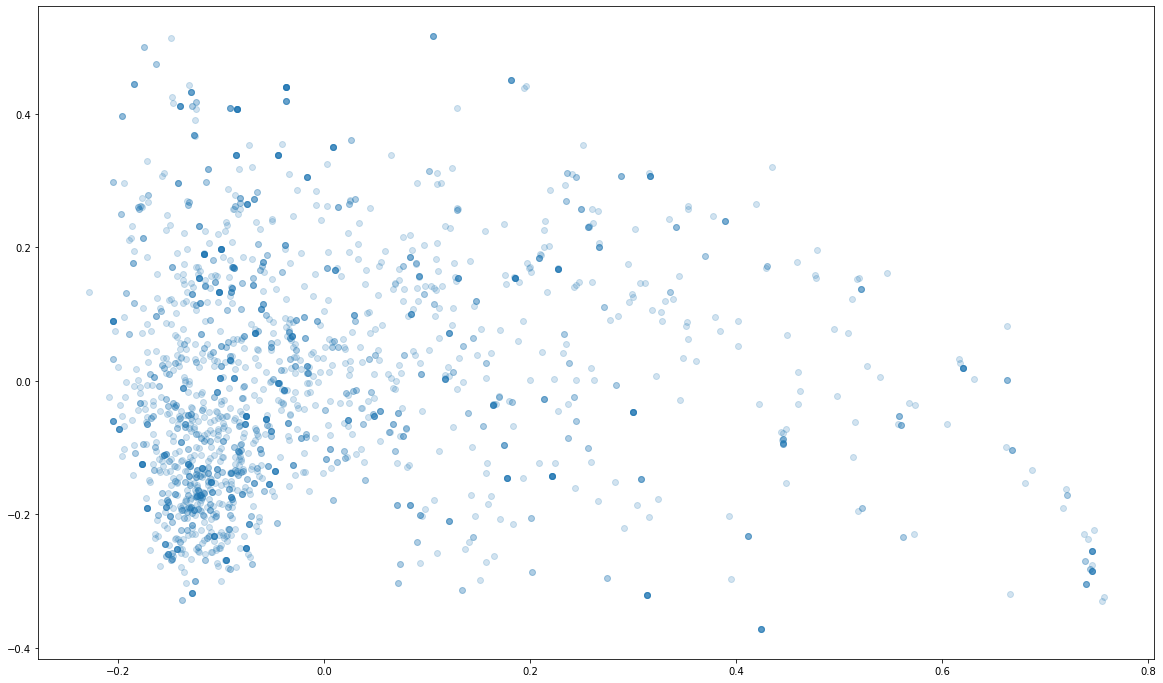

In [10]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

temp_list = []
for i in vector:
    temp_list.append(list(i.A[0]))


pca = PCA(n_components=2)
x_matrix = vector.todense()
pca.fit(temp_list)
X = pca.transform(temp_list)


fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)

#for i, txt in enumerate(df['title'].to_list()):
#    ax.annotate(txt, (X[:, 0][i], X[:, 1][i]))

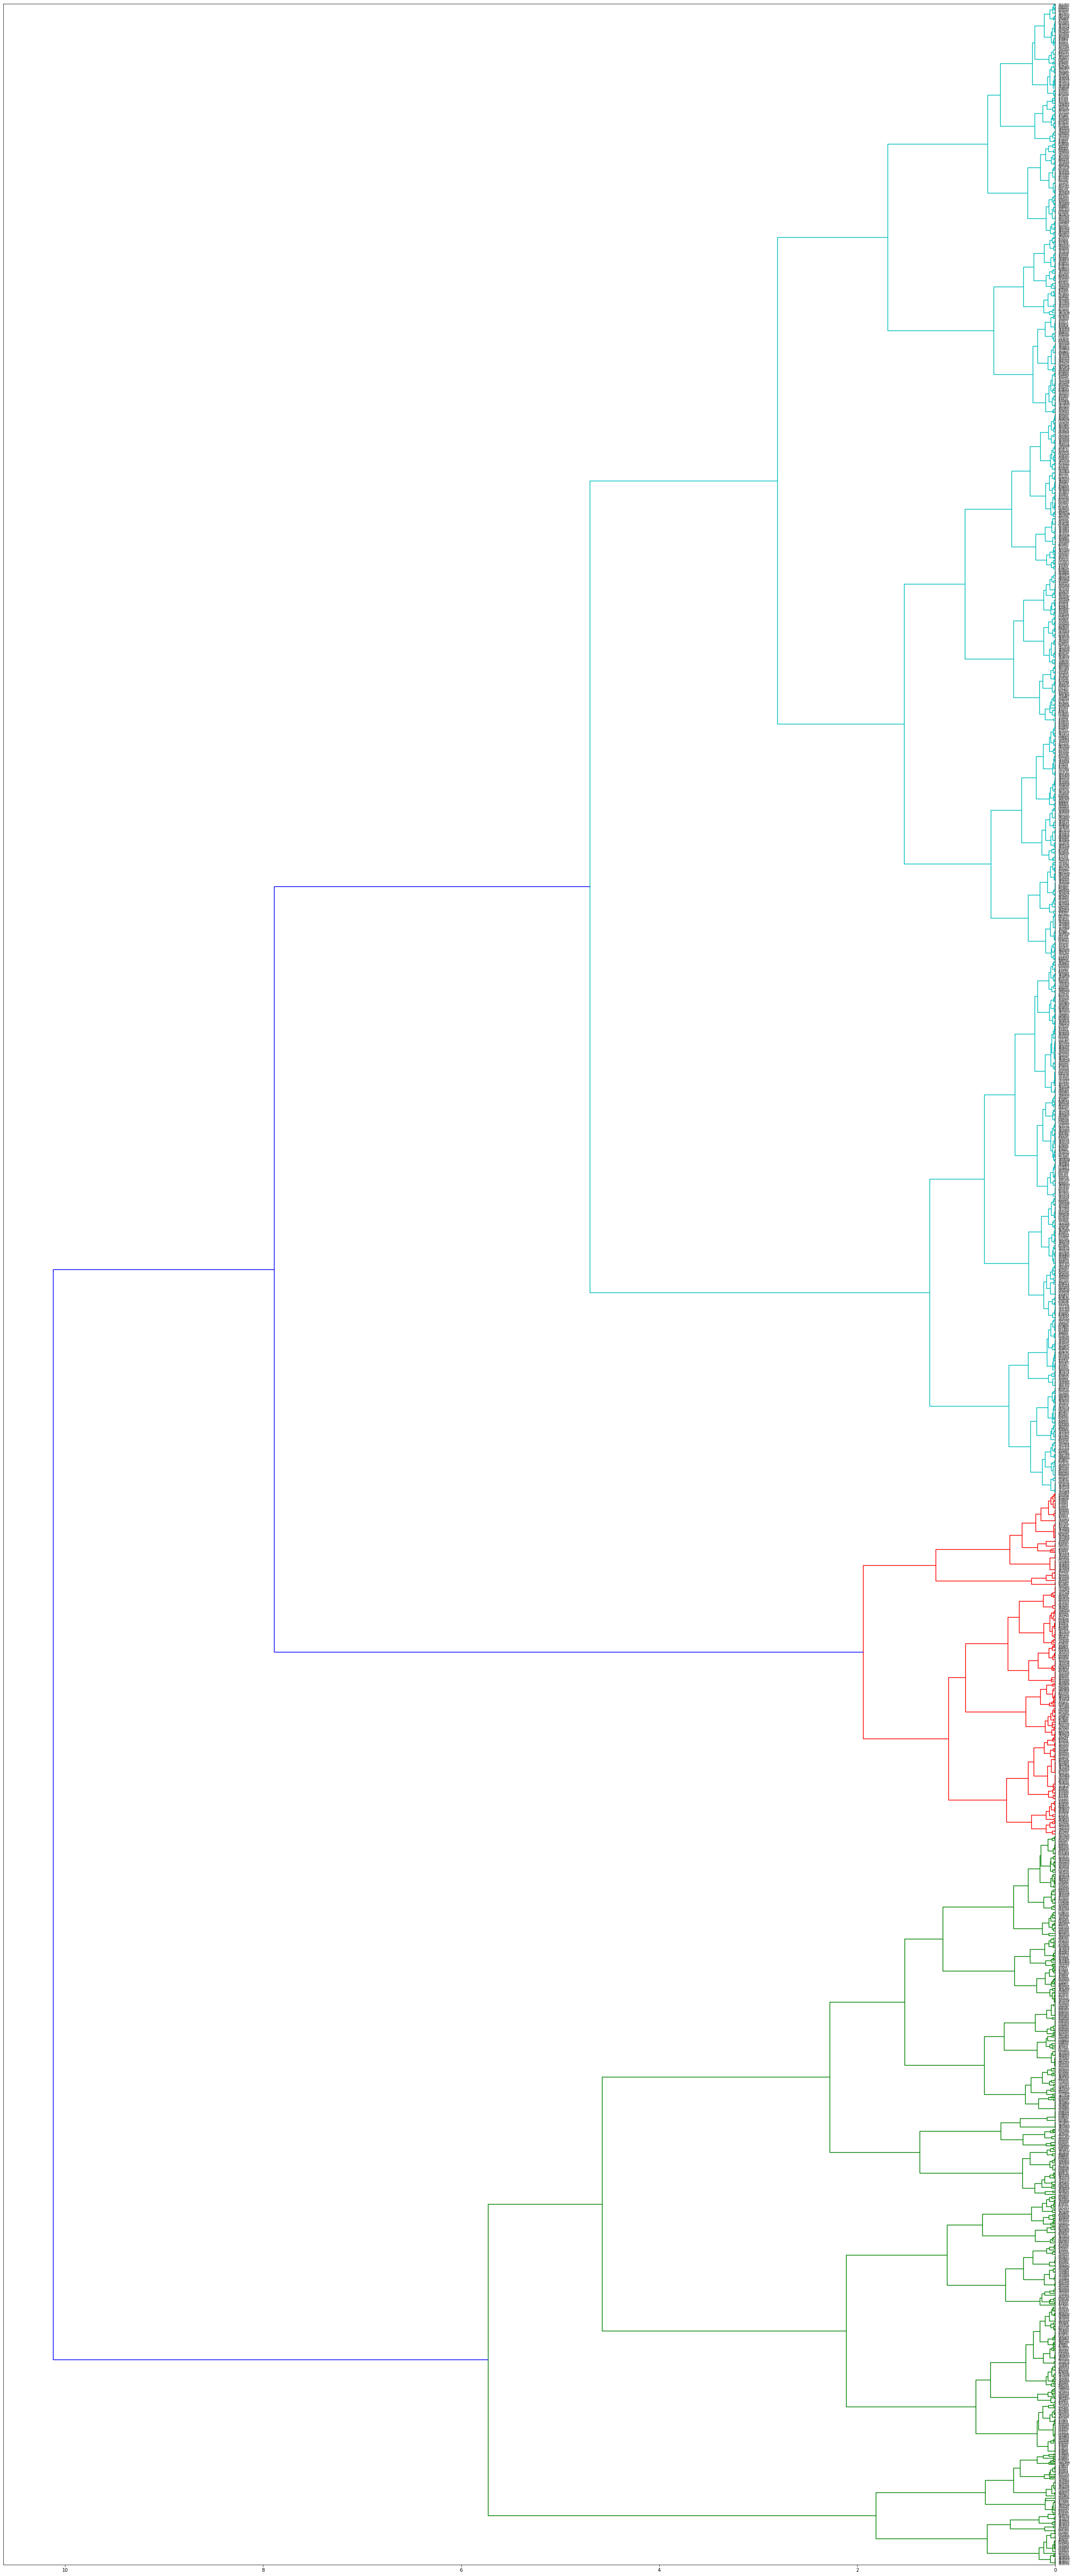

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

#  The distance function can be ‘braycurtis’, ‘canberra’, 
#‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, 
# ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
# ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

#dist = 1 - cosine_similarity(tfidf_matrix)
#MDS()
#mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
#pos = mds.fit_transform(tfidf_matrix.todense())  # shape (n_components, n_samples)

linked = linkage(X, 'ward', 'euclidean')
#linked = linkage(X, 'average', 'cosine')
#linked = linkage(x_matrix, 'ward', 'euclidean')
#linked = linkage(X, 'ward', 'euclidean')

labelList = list(drugs.keys())

plt.figure(figsize=(40, 100))  
dendrogram(linked,  
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [12]:
from sklearn.cluster import KMeans

num_clusters = 112

km = KMeans(n_clusters=num_clusters)

%time clusters=km.fit_predict(X)
#%time clusters=km.fit_predict(x_matrix)

#clusters = km.labels_.tolist()
print(clusters)

CPU times: user 1.68 s, sys: 210 ms, total: 1.89 s
Wall time: 682 ms
[80 80 80 ... 16 49 37]


In [13]:
solr = pysolr.Solr('http://librairy.linkeddata.es/data/atc')

atc_code_sample = "J05AB01"
atc_code_name = ""
for result in solr.search("code_s:"+atc_code_sample):
    atc_code_name = result['label_t']

sample_idx = labelList.index(atc_code_sample)
sample_cluster = clusters[sample_idx]
print("Cluster #", sample_cluster)

i = 0;
founds = []
for cluster in clusters:
    if (cluster == sample_cluster):
        founds.append(labelList[i])
    i+=1
print(len(founds),"drugs found related to",atc_code_sample,":",atc_code_name)
max = 10
for found in founds:
    for atc_code in solr.search("code_s:"+found):
        print("->",atc_code['code_s'],":",atc_code['label_t'])

Cluster # 96
34 drugs found related to J05AB01 : aciclovir
-> J01XX01 : fosfomycin
-> V03AB15 : naloxone
-> A06AH04 : naloxone
-> N01AX03 : ketamine
-> P02CB01 : piperazine
-> R03DA09 : acefylline piperazine
-> A16AB16 : idursulfase beta
-> L01XC16 : dinutuximab beta
-> A16AB04 : agalsidase beta
-> G03GA06 : follitropin beta
-> V08BA02 : barium sulfate without suspending agents
-> V08BA01 : barium sulfate with suspending agents
-> S01AD03 : aciclovir
-> D06BB03 : aciclovir
-> J05AB01 : aciclovir
-> D06BB53 : aciclovir, combinations
-> S01AX09 : chlorhexidine
-> S03AA04 : chlorhexidine
-> S02AA09 : chlorhexidine
-> D09AA12 : chlorhexidine
-> R02AA05 : chlorhexidine
-> B05CA02 : chlorhexidine
-> D08AC02 : chlorhexidine
-> A01AB03 : chlorhexidine
-> D08AC52 : chlorhexidine, combinations
-> P01BE03 : artesunate
-> P01BF06 : artesunate and pyronaridine
-> P01BA06 : amodiaquine
-> M03AC09 : rocuronium bromide
-> R05DA04 : codeine
-> N02AA59 : codeine, combinations excl. psycholeptics
-> N02A

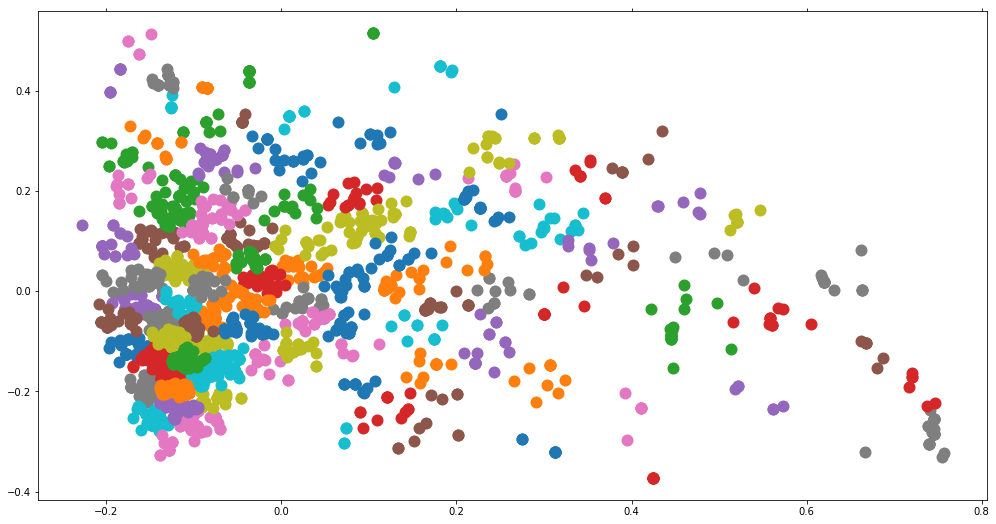

In [14]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

xs, ys = X[:, 0], X[:, 1]

#create data frame that has the result of the MDS plus the cluster numbers and titles
df2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=labelList)) 

#group by cluster
groups = df2.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    #ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
    #        label=cluster_names[name], color=cluster_colors[name], 
    #        mec='none')
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
             mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
#ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
    #ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

For n_clusters = 100 The average silhouette_score is : 0.436208445103141
For n_clusters = 110 The average silhouette_score is : 0.4494331459873356
For n_clusters = 120 The average silhouette_score is : 0.4576435692957037
For n_clusters = 130 The average silhouette_score is : 0.4553701275038375
For n_clusters = 140 The average silhouette_score is : 0.46024923069398316


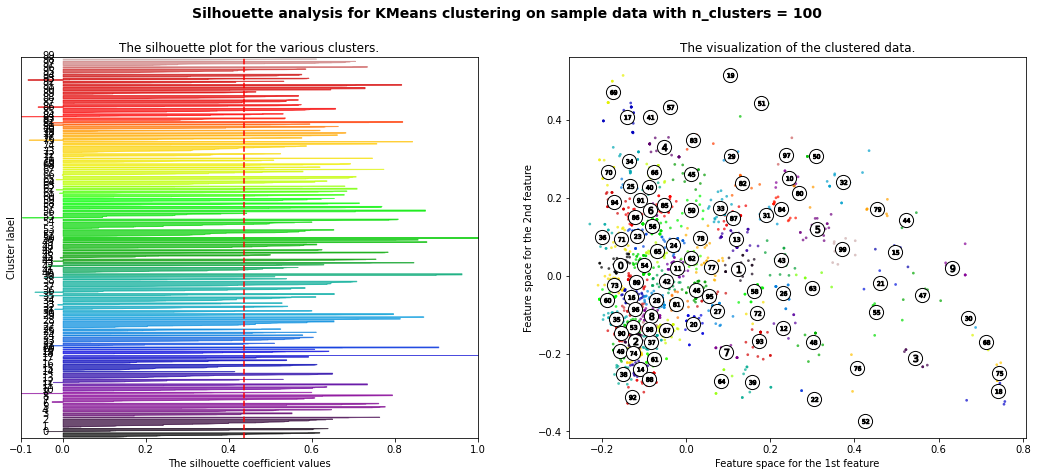

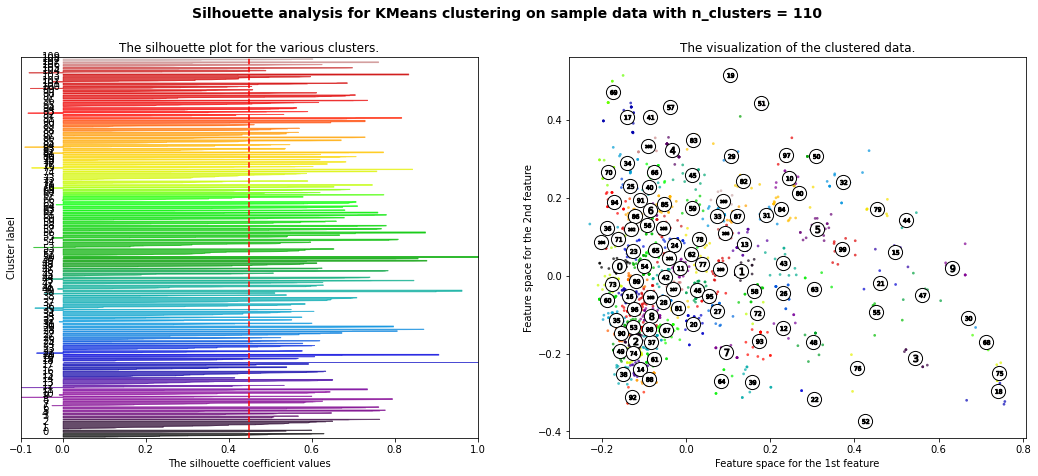

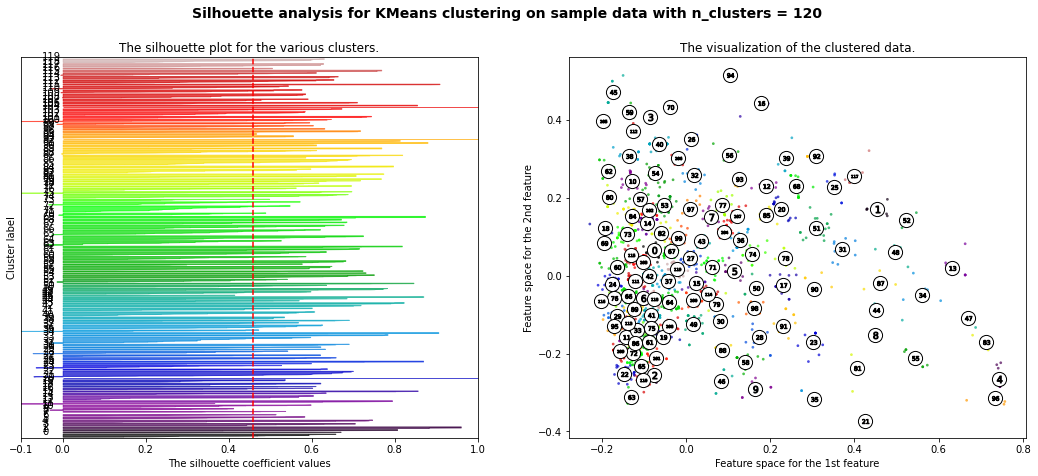

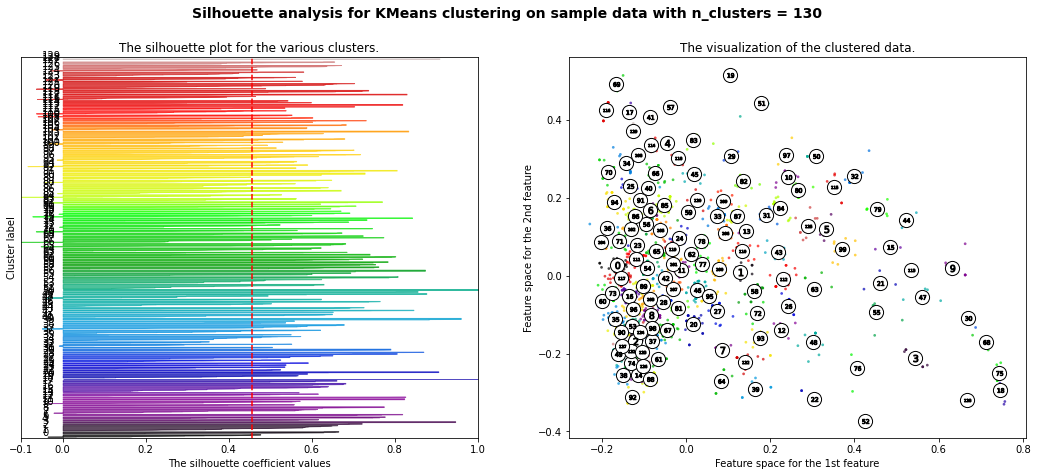

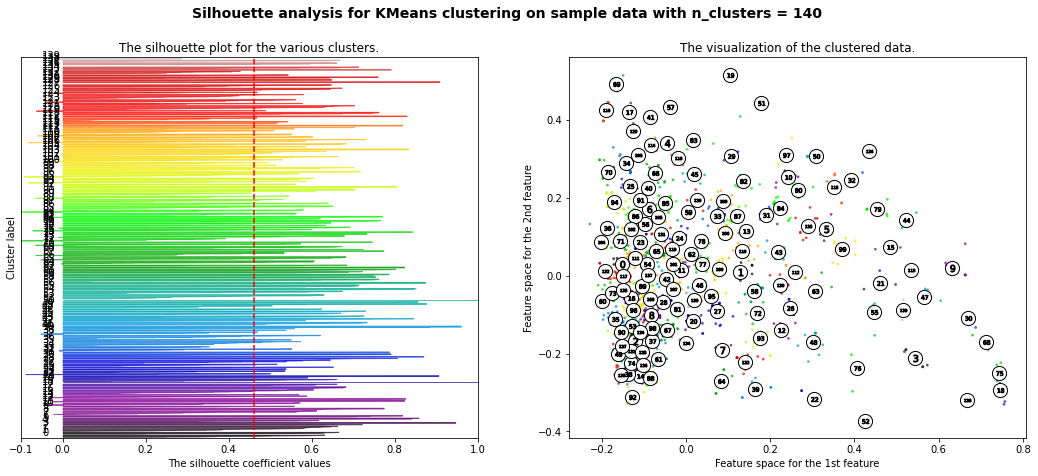

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [100, 110, 120, 130, 140]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Some Queries

In [ ]:
from annoy import AnnoyIndex

#Metric can be "angular", "euclidean", "manhattan", "hamming", or "dot".
class Space:
  def __init__(self, dimension, name, distance='euclidean',trees=1):
    self.name = name
    self.distance = distance
    self.trees = trees    
    self.vocab = []
    self.embedding_dict = {}
    self.size = 0
    self.dimension = dimension
    self.tree = AnnoyIndex(self.dimension, self.distance)
        
  def get_id(self):
    return self.name+"_"+self.distance[0]+"_"+str(self.trees)

  def get_vector(self,word):
    index  = self.embedding_dict[word]
    vector = self.tree.get_item_vector(index)
    array = np.array(vector) 
    return array
  
  def get_words(self,array,num):
    vector   = array.tolist()  
    nearest_idx = self.tree.get_nns_by_vector(vector, num)
    nearest_words = [self.vocab[i] for i in nearest_idx]
    return nearest_words

  def add_word(self,word,vector):
    if (self.dimension < 0):
      self.dimension = len(vector)
    self.vocab.append(word)  
    self.tree.add_item(self.size, vector)
    self.embedding_dict[word]=self.size
    self.size+=1

  def build(self):
    self.tree.build(self.trees)  
    
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#pca.fit(X)
#X2 = pca.transform(X)
    
space = Space(13,"test")

i=0
for row in temp_list[:10]:
    word = labelList[i]
    word_vector = [ j*1000 for j in row]
    print(word_vector)
    space.add_word(word,word_vector)
    i+=1
print(i,"words indexed in annoy")



In [ ]:
import numpy as np
vector = space.get_vector("N03AB03")
print(vector)
for neighbour in space.get_words(vector,10):
    print(label,neighbour)
print("done!")

In [ ]:
print(space.tree.get_nns_by_item(0, 2))

In [ ]:
from annoy import AnnoyIndex
import random

f = 2
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(13):
    v = [random.gauss(0, 1) for z in range(f)]
    print(v)
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('test.ann')

# ...

u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file
print(u.get_nns_by_item(0, 5)) # will find the 1000 nearest neighbors
